In [598]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from xgboost import XGBClassifier


# Data Wrangling

In [599]:
df = pd.read_csv('diabetic_data.csv')

In [600]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

At face value, it appears that there are no variables for which there are missing values; however, I find this extremely
unlikely. Let's take a look at the top few rows of each variable, to get a sense for how the data is entered and for 
any cases of missing values.

### Wrangling and cleaning - categorical data

In [601]:
cat_df = df.select_dtypes(include=['object'])
for col in cat_df.columns:
    print(cat_df[col][0:10])

0          Caucasian
1          Caucasian
2    AfricanAmerican
3          Caucasian
4          Caucasian
5          Caucasian
6          Caucasian
7          Caucasian
8          Caucasian
9          Caucasian
Name: race, dtype: object
0    Female
1    Female
2    Female
3      Male
4      Male
5      Male
6      Male
7      Male
8    Female
9    Female
Name: gender, dtype: object
0      [0-10)
1     [10-20)
2     [20-30)
3     [30-40)
4     [40-50)
5     [50-60)
6     [60-70)
7     [70-80)
8     [80-90)
9    [90-100)
Name: age, dtype: object
0    ?
1    ?
2    ?
3    ?
4    ?
5    ?
6    ?
7    ?
8    ?
9    ?
Name: weight, dtype: object
0    ?
1    ?
2    ?
3    ?
4    ?
5    ?
6    ?
7    ?
8    ?
9    ?
Name: payer_code, dtype: object
0    Pediatrics-Endocrinology
1                           ?
2                           ?
3                           ?
4                           ?
5                           ?
6                           ?
7                           ?
8          

As we can see, there are a few columns for which there is missing data, which is entered as a '?' in this case. Before we decide what to do with missing data, however, it might be worth considering just how bad the problem is for each variable.

In [602]:
for col in cat_df.columns:
    if len(cat_df[cat_df[col]=='?'])*100/101766 > 0: #Only print variables which have more than one missing value
        print('The percentage of missing data for variable {} is {}%'.format(col, len(cat_df[cat_df[col]=='?'])*100/101766))

The percentage of missing data for variable race is 2.2335554114340743%
The percentage of missing data for variable weight is 96.85847925633315%
The percentage of missing data for variable payer_code is 39.5574160328597%
The percentage of missing data for variable medical_specialty is 49.08220820313268%
The percentage of missing data for variable diag_1 is 0.020635575732562937%
The percentage of missing data for variable diag_2 is 0.3517874339170253%
The percentage of missing data for variable diag_3 is 1.398305917497003%


The problem appears to be extremely severe with regards to weight, with almost all the data missing. In this case I 
would recommend simply discarding the variable as there is little information to be gleaned. Similarly, payer code is unlikely to hold much medical significance, and I will discard it here. 

However, despite its high almost 50%) missing data, I would recommend keeping the medical specialty associated with a given patient as this can constitute valuable information for a model. In this case, I will simply impute 'Unknown' to replace the current '?' value. 

The same approach will be taken for the other variables with missing data, as the problem is relatively small there.

In [603]:
df = df.drop(['weight', 'payer_code'], axis=1)
df = df.replace('?', 'Unknown')

# Wrangling - re-grouping diagnoses

Reading the original research paper from which this dataset was derived, the 'diag_1', 'diag_2', and 'diag_3' variables
represent primary, secondary, and additional diagnoses associated with the patient. These variables are entered as 
numbers, but the real meaning of these numbers are categorical associations with disease types. To that end, I will 
recode these variables to make it clearer.

In [604]:
df.loc[df['diag_1'].str.contains('E|V|U', regex=True), 'diag_1'] = '10000'
df.loc[df['diag_1'].str.contains('250'), 'diag_1'] = '250'
df['diag_1'] = df['diag_1'].astype(int)
df.loc[df['diag_2'].str.contains('E|V|U', regex=True), 'diag_2'] = '10000'
df.loc[df['diag_2'].str.contains('250'), 'diag_2'] = '250'
df['diag_2'] = df['diag_2'].astype(int)
df.loc[df['diag_3'].str.contains('E|V|U', regex=True), 'diag_3'] = '10000'
df.loc[df['diag_3'].str.contains('250'), 'diag_3'] = '250'
df.loc[df['diag_3'].str.contains('365'), 'diag_3'] = '360'
df['diag_3'] = df['diag_3'].astype(int)

In [605]:
bins = [0, 251, 280, 398, 460, 520, 580, 630, 680, 710, 740, 760,
        785, 786, 787, 788, 789, 800, 1000, np.inf]
names = ['Neoplasms', 'Diabetes', 'Neoplasms', 'Other', 'Circulatory',
         'Respiratory', 'Digestive', 'Genitourinary', 'Other', 'Neplasms',
         'Musculoskeletal', 'Other', 'Neoplasms', 'Circulatory', 'Respiratory',
         'Digestive', 'Genitourinary', 'Neoplasms', 'Injury']

d = dict(enumerate(names, 1))
d

df['diag_1'] = np.vectorize(d.get)(np.digitize(df['diag_1'], bins))
df['diag_2'] = np.vectorize(d.get)(np.digitize(df['diag_2'], bins))
df['diag_3'] = np.vectorize(d.get)(np.digitize(df['diag_3'], bins))

### Wrangling and cleaning - numerical data

In [606]:
num_df = df.select_dtypes(include=['int64', 'float64'])
num_df.isna().sum()

encounter_id                0
patient_nbr                 0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
dtype: int64

Apparently, there are no instances where there is missing data in numerical data. All the better for us! 

A quick processing step, which we will need later: I will convert the int64 columns to float; also, I will need
to convert the discharge_disposition_id and admission_source_id variables from numeric to categorical.

In [607]:
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('category')
df['admission_source_id'] = df['admission_source_id'].astype('category')
num_vars = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_vars:
    df[col] = df[col].astype(float)

### Further wrangling

In [609]:
df= df.sort_values(by=['patient_nbr', 'encounter_id'])
print(df.head())

       encounter_id  patient_nbr       race  gender      age  \
4267     24437208.0        135.0  Caucasian  Female  [50-60)   
4780     26264286.0        135.0  Caucasian  Female  [50-60)   
5827     29758806.0        378.0  Caucasian  Female  [50-60)   
67608   189899286.0        729.0  Caucasian  Female  [80-90)   
17494    64331490.0        774.0  Caucasian  Female  [80-90)   

       admission_type_id discharge_disposition_id admission_source_id  \
4267                 2.0                        1                   1   
4780                 1.0                        1                   7   
5827                 3.0                        1                   1   
67608                1.0                        3                   7   
17494                1.0                        1                   7   

       time_in_hospital                medical_specialty     ...      \
4267                8.0                       Cardiology     ...       
4780                3.0  Surgery

From this quick exploration, we can see that there is a situation where there are some patients who have multiple 
encounters. This creates a difficult statistical question, as it essentially creates multiple patients who are almost
100% correlated with another patient (i.e. themselves) with regards to demographic variables. 

What I will do in this case, for the sake of simplicity and as a starting case, is to keep only the first instance of individuals which have multiple hospital visits. Further, I will drop encounter_id and patient_nbr, as these are simply identifiers and not actually a source of predictive value.

In [610]:
df = df.drop_duplicates(subset=['patient_nbr'], keep='first')
df = df.drop(['encounter_id', 'patient_nbr'],axis=1)

# Data Approach 1 - Simple dataset - Binary Classification

For this dataset, I will recode the admissions column to reflect only binary outcomes for readmissions: Yes and No.

In [661]:
binary_df = df.copy()
binary_df['readmitted'] = binary_df['readmitted'].map({'<30':'YES', '>30':'YES', 'NO':'NO'}) 

# Export for future use
binary_df.to_csv('binary_diabetes.csv')

## Preprocessing

In [ ]:
y = binary_df['readmitted'] 
X = binary_df.drop('readmitted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = simple_df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = simple_df.select_dtypes(include=['object']).drop(['readmitted'], axis=1).columns

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                              ('cat', categorical_transformer, categorical_features)])

In [614]:
def classification_model_fit(model, parameter_grid):
    """Function to simplify the model fitting process
    """
    clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('clf', model)])
    clf_cv = GridSearchCV(clf_pipeline, parameter_grid, cv=3)
    fitted_model = clf_cv.fit(X_train, y_train)
    return(fitted_model)

In [644]:
def evaluate_classification_model(model):
    model_predictions = model.predict(X_test)
    model_accuracy = accuracy_score(model_predictions, y_test)
    
    model_report = classification_report(model_predictions, y_test)
    
    model_roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return model_accuracy, model_report, model_roc_score

## Model 1 - Logistic Regression

In [616]:
# Fitting the model
simple_logreg_params = {'clf__penalty':['l1','l2'], 'clf__C':np.linspace(0.5,1.5,5), 'clf__solver':['liblinear']}
simple_logreg = classification_model_fit(LogisticRegression(), simple_logreg_params)

In [639]:
#Extracting coefficients
simple_logreg_coef = simple_logreg.best_estimator_.named_steps['clf'].coef_

In [650]:
# Evaluating the model
logreg_acc, logreg_classification, logreg_roc = evaluate_classification_model(simple_logreg)
print("The accuracy of the logistic regression classifier is {}".format(logreg_acc))
print("The classification report of the logistic regression classifier is\n {}".format(logreg_classification))
print("The ROC-AUC score of the logistic regression classifier is {}".format(logreg_roc))

The accuracy of the logistic regression classifier is 0.6300335570469798
The classification report of the logistic regression classifier is
               precision    recall  f1-score   support

          NO       0.90      0.64      0.74     18212
         YES       0.23      0.60      0.33      3244

   micro avg       0.63      0.63      0.63     21456
   macro avg       0.56      0.62      0.54     21456
weighted avg       0.80      0.63      0.68     21456

The ROC-AUC score of the logistic regression classifier is 0.6363374555755896


In [562]:
onehotfeatures = simple_logreg.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names(categorical_features)
_ = list(numeric_features.copy())

test = [str(i) for i in onehotfeatures]
for i in test:
    _.append(i)

## Model 2 - XGBClassifier

In [651]:
simple_xgb_params = {'clf__max_depth':[10, 20, 30, 40, 50], 'clf__objective':['binary:logistic']}
simple_xgb = classification_model_fit(XGBClassifier(), simple_xgb_params)

In [ ]:
#Extracting feature importances
simple_logreg_coef = simple_logreg.best_estimator_.named_steps['clf'].

In [652]:
# Evaluating the model
simple_xgb_acc, simple_xgb_classification, simple_xgb_roc = evaluate_classification_model(simple_xgb)
print("The accuracy of the XGBoost classifier is {}".format(simple_xgb_acc))
print("The classification report of the XGBoost classifier is\n {}".format(simple_xgb_classification))
print("The ROC-AUC score of the XGBoost classifier is {}".format(simple_xgb_roc))

The accuracy of the XGBoost classifier is 0.6313851603281133
The classification report of the XGBoost classifier is
               precision    recall  f1-score   support

          NO       0.84      0.65      0.73     16771
         YES       0.31      0.57      0.40      4685

   micro avg       0.63      0.63      0.63     21456
   macro avg       0.58      0.61      0.57     21456
weighted avg       0.73      0.63      0.66     21456

The ROC-AUC score of the XGBoost classifier is 0.6438421507574617


## Model 3 - Random Forest

In [653]:
simple_rf_params = {'clf__n_estimators': [200, 300, 400], 'clf__max_depth': [10, 20, 30, 40, 50], 
             'clf__max_features': ['auto', 'sqrt'], 'clf__class_weight':['balanced']}
simple_rf = classification_model_fit(RandomForestClassifier(), simple_rf_params)

In [ ]:
#Extracting coefficients
simple_logreg_coef = simple_logreg.best_estimator_.named_steps['clf'].coef_

In [654]:
# Evaluating the model
simple_rf_acc, simple_rf_classification, simple_rf_roc = evaluate_classification_model(simple_rf)
print("The accuracy of the Random Forest classifier is {}".format(simple_rf_acc))
print("The classification report of the Random Forest classifier is\n {}".format(simple_rf_classification))
print("The ROC-AUC score of the Random Forest classifier is {}".format(simple_rf_roc))

The accuracy of the Random Forest classifier is 0.627703206562267
The classification report of the Random Forest classifier is
               precision    recall  f1-score   support

          NO       0.82      0.65      0.73     16278
         YES       0.34      0.56      0.42      5178

   micro avg       0.63      0.63      0.63     21456
   macro avg       0.58      0.60      0.57     21456
weighted avg       0.70      0.63      0.65     21456

The ROC-AUC score of the Random Forest classifier is 0.6432134647271631


# Data Approach 2 - Multiclass problem

## Preprocessing

In [92]:
y = df['readmitted'] 
X = df.drop('readmitted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).drop(['readmitted'], axis=1).columns

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                              ('cat', categorical_transformer, categorical_features)])

## Model #1 - XGBoost Classifier

In [60]:
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('xgb_clf', XGBClassifier())])
xgb_params = {'xgb_clf__max_depth':[10, 20, 30, 40, 50], 'xgb_clf__objective':['multi:softprob'], 
              'xgb_clf__num_class':[3]}
# Tune parameters
xgb_cv = GridSearchCV(xgb_pipeline, xgb_params, cv = 3)
# Fit pipeline to training set
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), Index(['encounter_id', 'patient_n...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgb_clf__max_depth': [10, 20, 30, 40, 50], 'xgb_clf__objective': ['multi:softprob'], 'xgb_clf__num_class': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [113]:
print(xgb_cv.best_params_)

tuned_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('xgb_clf', XGBClassifier(max_depth=10, num_class=3,
                                                                                      objective='multi:softprob'))])
tuned_xgb.fit(X_train, y_train)
importances = tuned_xgb.named_steps['xgb_clf'].feature_importances_ # Extract feature importances

{'xgb_clf__max_depth': 10, 'xgb_clf__num_class': 3, 'xgb_clf__objective': 'multi:softprob'}


### Evaluate the model

In [69]:
xgb_ypred = xgb_cv.predict(X_test)
xgb_acc = accuracy_score(xgb_ypred, y_test)
print('Accuracy of XGBClassifier is {}'.format(xgb_acc))
xgb_report = classification_report(xgb_ypred, y_test)
print('Classification report of XGBClassifier is \n {}'.format(xgb_report))

Accuracy of XGBClassifier is 0.6369313944817301
Classification report of XGBClassifier is 
               precision    recall  f1-score   support

         <30       0.03      0.43      0.06       142
         >30       0.34      0.53      0.41      4266
          NO       0.88      0.67      0.76     17048

   micro avg       0.64      0.64      0.64     21456
   macro avg       0.42      0.54      0.41     21456
weighted avg       0.77      0.64      0.68     21456



Something concerning for me is the low f1-score for the class '<30'. The poorer performance makes sense given that those 
patients are the significant minority and as such, have a very low precision score. I will note that the recall for
this minority group is 0.43; not fantastic, but much better than what one would imagine just looking at the f1-score. 

As predicting this minority group of readmitted patients is where we should placing our emphasis anyway, I am quite satisfied with the idea of a model that has lower precision but high recall for our purposes. 

In [78]:
xgb_feature_importances = xgb_cv.best_estimator_.named_steps['xgb_clf'].feature_importances_

# Model #2 - Random Forest Classifier (weighted classes)

In [72]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('rf_clf', RandomForestClassifier())])
rf_params = {'rf_clf__n_estimators': [200, 300, 400],
            'rf_clf__max_depth': [10, 20, 30, 40, 50],
            'rf_clf__max_features': ['auto', 'sqrt'],
            'rf_clf__class_weight':['balanced']}
# Tune parameters
rf_cv = GridSearchCV(rf_pipeline, rf_params, cv = 3)
# Fit pipeline to training set
rf_cv.fit(X_train, y_train)

print(rf_cv.best_params_)

{'rf_clf__class_weight': 'balanced', 'rf_clf__max_depth': 40, 'rf_clf__max_features': 'auto', 'rf_clf__n_estimators': 400}


### Evaluating the Random Forest model

In [75]:
rf_ypred = rf_cv.predict(X_test)
rf_acc = accuracy_score(rf_ypred, y_test)
print(rf_acc)
rf_report = classification_report(rf_ypred, y_test)
print('Confusion matrix of XGBClassifier is \n {}'.format(rf_report))

0.631851230425056
Confusion matrix of XGBClassifier is 
               precision    recall  f1-score   support

         <30       0.01      0.36      0.03        74
         >30       0.34      0.51      0.41      4435
          NO       0.87      0.66      0.75     16947

   micro avg       0.63      0.63      0.63     21456
   macro avg       0.41      0.51      0.40     21456
weighted avg       0.76      0.63      0.68     21456



Similar to the XGBoost model, the f1-score gives a somewhat misleading picture of what is happening in the model.
Like before, the recall for the smallest class (<30 days) is much higher than its f1-score would suggest.

However, we should note that the Random Forest model, evaluated on the recall metric, ends up performing worse than
XGBoost.

In [470]:
tuned_xgb.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names()

array(['x0_AfricanAmerican', 'x0_Asian', 'x0_Caucasian', ..., 'x33_No',
       'x34_No', 'x34_Yes'], dtype=object)

In [517]:
len(num_vars)

11

In [512]:
print(len(importances))
print(len(feature_names))

2244
2242


In [509]:
# Minor wrangling to create dataset with feature names and linear coefficients
feature_names = list(num_vars) # Initialize list of feature names with numerical variables
onehot_features = tuned_xgb.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names()
onehot_features = [str(var) for var in onehot_features]

for var in onehot_features:
    feature_names.append(var)
    
xgb_importance_df = pd.DataFrame({"Feature Names": feature_names,
                                     "XGB Importances":importances})

ValueError: arrays must all be same length

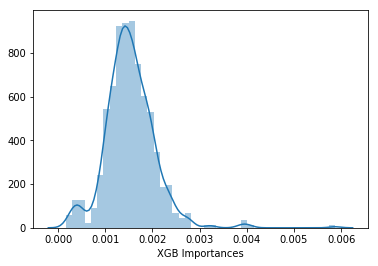

,Feature Names,XGB Importances
1857,diag_3_648,0.000168
799,diag_2_154,0.000236
1823,diag_3_593,0.000269
553,diag_1_659,0.000280
530,diag_1_626,0.000293
294,diag_1_331,0.000310
2132,diag_3_V10,0.000314
552,diag_1_658,0.000316
834,diag_2_218,0.000337
1870,diag_3_664,0.000342


In [172]:
xgb_importance_df = xgb_importance_df[xgb_importance_df['XGB Importances'] > 0]
sns.distplot(xgb_importance_df['XGB Importances'])
plt.show()

xgb_importance_df = xgb_importance_df.sort_values(by='XGB Importances')
xgb_importance_df.head(n=20)

In [ ]:

elasticnet_coefs = gm_cv.best_estimator_.named_steps['elasticnet'].coef_
elasticnet_df = pd.DataFrame({"Feature Names": feature_names, 
                           "Coefficients":elasticnet_coefs}) 

feature_importance_coef_df = pd.merge(feature_importance_df, elasticnet_df, how='inner', on ='Feature Names')
rf_feature_df = feature_importance_coef_df.sort_values(by="Random Forest Importances", ascending=False)
print(rf_feature_df[['Feature Names', 'Random Forest Importances', 'Coefficients']].head(n=10)) # Top 10 features of 